# Project: Image Deblurring


## Image Blurrer

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from matplotlib.image import imread
from scipy.signal import convolve2d
import scipy.linalg as sla
from scipy.sparse.linalg import svds
import math
import cv2

### Functions

In [35]:
def guassian_kernel(m,n,sig):
    ax = np.linspace(-(m - 1) / 2., (m - 1) / 2., m)
    ay = np.linspace(-(n - 1) / 2., (m - 1) / 2., m)
    xx, yy = np.meshgrid(ax, ay)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)


def add_sp_noise(img,p):
    row , col = img.shape
    a = row*col
    
    num = int(a*p)//2
    for i in range(num):
        
        # Pick a random y coordinate
        y=random.randint(0, row - 1)

        x=random.randint(0, col - 1)

        img[y][x] = 255

    for i in range(num):
        y=random.randint(0, row - 1)
          
        x=random.randint(0, col - 1)
        
        img[y][x] = 0
          
    return img


        
def add_Guassian_noise(img, var, mean):
    n,m = img.shape
    
    sig = np.sqrt(var)
    
    n = np.random.normal(loc=mean,scale=sig,size=(n,m))
    
    return img + n
    
def blur_image(img,psf):
    u, s, v = svds(psf,1)

    c = (np.sqrt(s)*u).flatten()
    r = (np.sqrt(s)*v).flatten()

    A_r = sla.convolution_matrix(r,n,'same')
    A_c = sla.convolution_matrix(c,m,'same')
    
    blurred = A_c @ f @ A_r.T 
    return blurred

def vectorize(V):
    l = V.shape[0]*V.shape[1]
    return V.reshape((l,1))

def de_vectorize(V,n,m):
    return V.reshape((n,m))

def Tikhonov_deblur(img,psf,lam):
    m,n = img.shape
    A = create_blur_matrix(psf,img)
    b = vectorize(img)
    A_T = A.T
    Aa_T = A @ A.T
    T = lam*np.identity((n*m))
    T_T = T.T
    TT_T = T @ T_T
    X  = Aa_T + TT_T
    X = sla.inv(X)
    ATb = A_T @ b
    F = X @ ATb
    f = de_vectorize(F,m,n)
    return f


def Tikhonov_deblur_fourier(img,psf,lam):
    s = img.shape  


    psf_fft = np.fft.fft2(psf, s=s)
    psf_mag = np.abs(psf_fft)**2
    img_fft = np.fft.fft2(img, s=s)
    result_fft = np.conj(psf_fft) / (psf_mag + lam)
    result_fft = result_fft * img_fft
    result = np.real(np.fft.ifft2(result_fft))
    
    return result
    
   
    
def turnacatedSVDReg(img,psf,k):
    m,n = img.shape
    u, s, v = svds(psf,1)

    c = (np.sqrt(s)*u).flatten()
    r = (np.sqrt(s)*v).flatten()

    A_r = sla.convolution_matrix(r,n,'same')
    A_c = sla.convolution_matrix(c,m,'same')
    
    Ua, Sa, Va = sla.svd(A_c)
    Ub, Sb, Vb = sla.svd(A_r) 
    
    U_1 = np.hstack([1/Sb[:k],np.zeros(n-k)])
    U_2 = np.hstack([1/Sa[:k],np.zeros(m-k)])
    
    
    Ac_turn = Va.T @ np.diag(U_2) @ Ua.T
    Ar_turn = Ub @ np.diag(U_1) @ Vb
    
    X = Ac_turn @ img @ Ar_turn
    
    return X
    
    
def create_blur_matrix(psf,img):
    u, s, v = svds(h,1)
    n,m = img.shape

    c = (np.sqrt(s)*u).flatten()
    r = (np.sqrt(s)*v).flatten()

    A_r = sla.convolution_matrix(r,n,'same')
    A_c = sla.convolution_matrix(c,m,'same')
    
    A = np.kron(A_r,A_c)
    return A

def sharpness(img):
    # convert to greyscale
    # grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate laplacian and variance
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    variance = np.var(laplacian)
    return variance
    
    
    

## Loading Image

(512, 512)


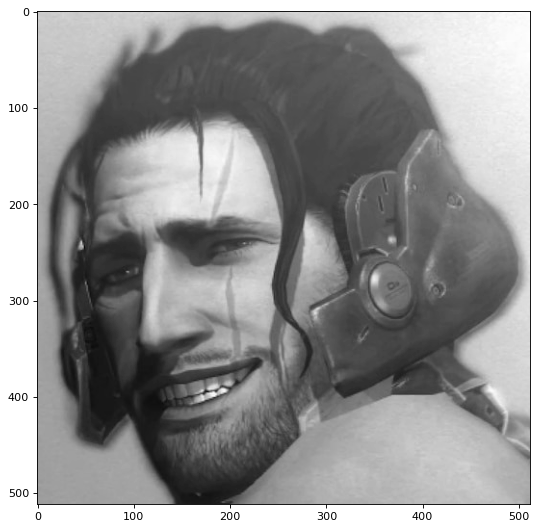

In [36]:
def load_image(file):
    image = rgb2gray(plt.imread(file))
    plt.figure(num=None, figsize=(8, 8), dpi=80)
    plt.imshow(image,cmap="gray")
    return image
f = load_image('images/image.jpg')
print(f.shape)

## blurring Image

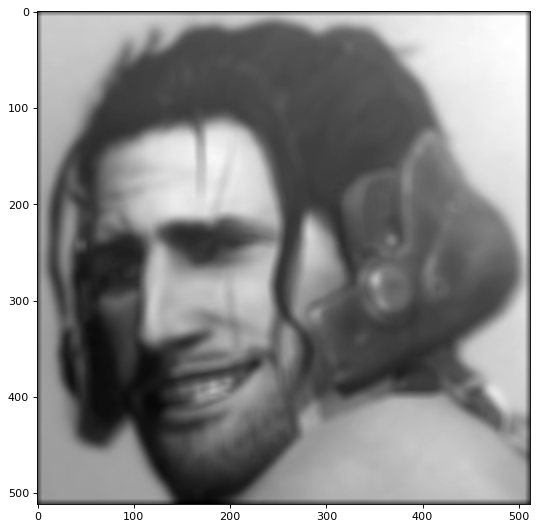

In [37]:
m,n = f.shape
h = guassian_kernel(11,11, 10)

u, s, v = svds(h,1)

c = (np.sqrt(s)*u).flatten()
r = (np.sqrt(s)*v).flatten()

c = (np.sqrt(s)*u).flatten()
r = (np.sqrt(s)*v).flatten()

A_r = sla.convolution_matrix(r,n,'same')
A_c = sla.convolution_matrix(c,m,'same')




blurred = blur_image(f,h)
blurred = add_Guassian_noise(blurred,0.000001,0)
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.imshow(blurred,cmap="gray")

## Niave DeBlurring

In [38]:
ac_1 = sla.inv(A_c)
ar_1t = sla.inv(A_r.T)
print(ac_1.shape)
print(ar_1t.shape)
x = ac_1@blurred@ar_1t

(512, 512)
(512, 512)


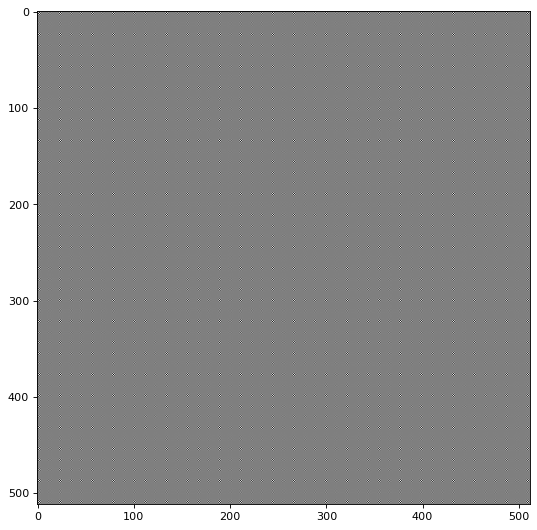

In [39]:
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.imshow(x,cmap="gray")

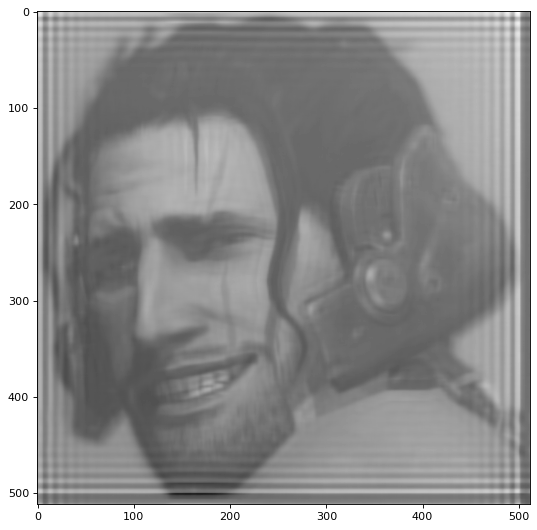

In [53]:
T= Tikhonov_deblur_fourier(blurred,h,0.01)
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.imshow(T,cmap="gray")

In [9]:
print(blurred.shape)

(512, 512)


(512, 512)


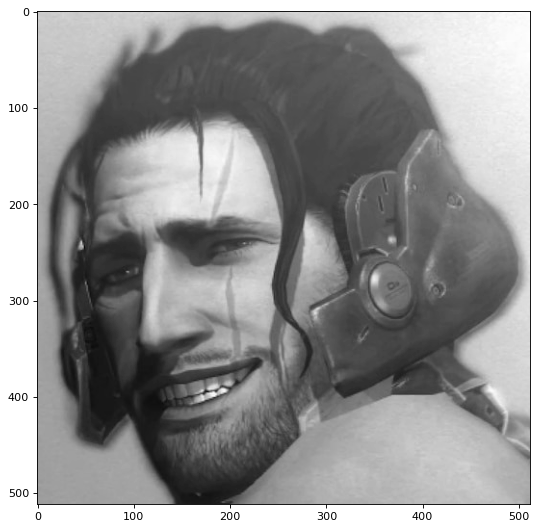

In [10]:
f = load_image('images/image.jpg')
print(f.shape)

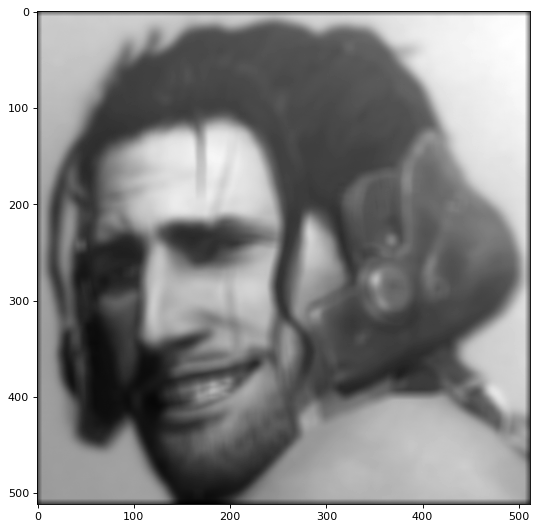

In [11]:
# blurred = blur_image(f,h)
# blurred = add_Guassian_noise(blurred,0.000001,0)
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.imshow(blurred,cmap="gray")

(512, 512)


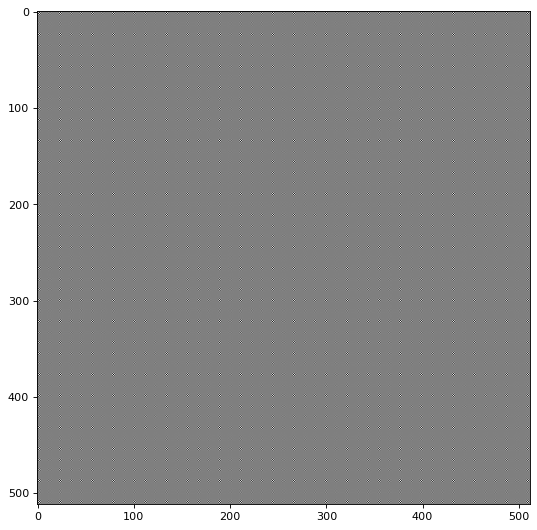

In [46]:
x = turnacatedSVDReg(blurred,h,200)
print(blurred.shape)
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.imshow(x,cmap="gray")

## Testing Truncated SVD

first we will test how well the image deblur works when we use a constant psf but change our constant for truncation (n)

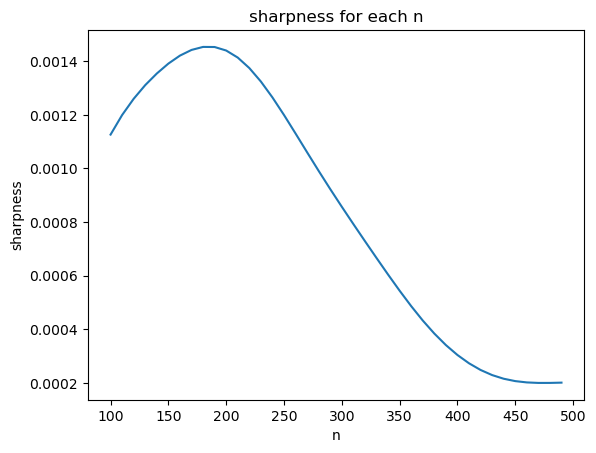

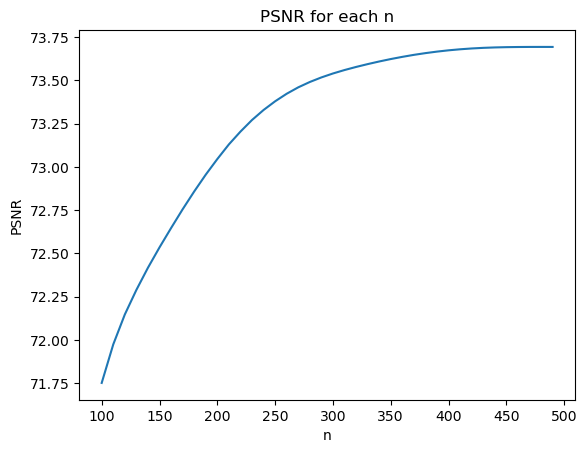

In [25]:
x = []
y = []
z = []
for i in range(100,500,10):
    
    x.append(i)
    b = turnacatedSVDReg(blurred,h,i)
    z.append(cv2.PSNR(f, b))
    y.append(sharpness(b))

plt.plot(x,y)
plt.xlabel('n')
plt.ylabel('sharpness')
plt.title("sharpness for each n")
plt.show()

plt.plot(x,z)
plt.xlabel('n')
plt.ylabel('PSNR')
plt.title("PSNR for each n")
plt.show()
    
    

next we will check how changing the lambda value in the psf 

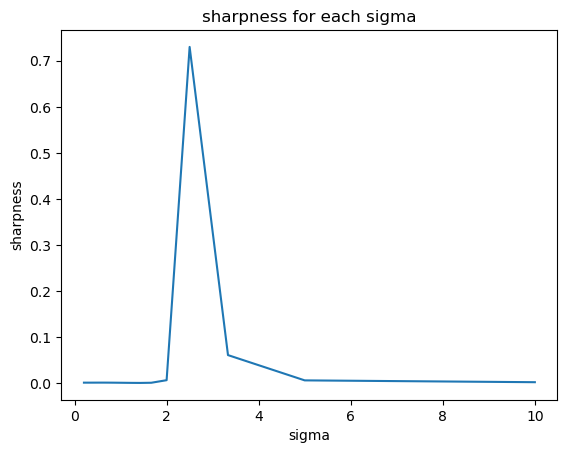

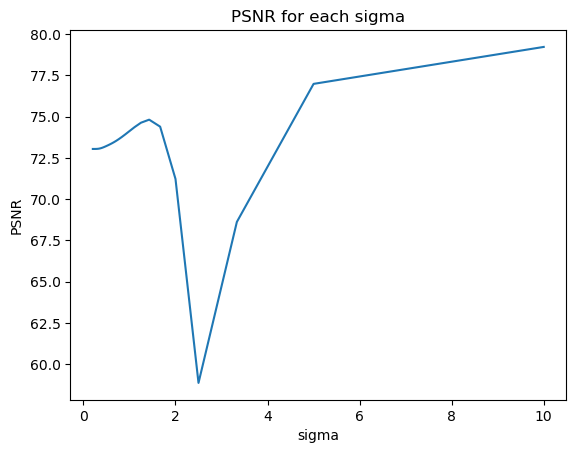

In [62]:
x = []
y = []
z = []
for i in range(1,50):
    psf = h = guassian_kernel(11,11, 10/i)
    b = turnacatedSVDReg(blurred,psf,200)
    x.append(10/i)
    y.append(sharpness(b))
    z.append(cv2.PSNR(b, f))
    
plt.plot(x,y)
plt.xlabel('sigma')
plt.ylabel('sharpness')
plt.title("sharpness for each sigma")
plt.show()   

plt.plot(x,z)
plt.xlabel('sigma')
plt.ylabel('PSNR')
plt.title("PSNR for each sigma")
plt.show()  

## Testing Tikhonov Regualrization

first we will check how the lambda parameter affects how well the tikhonov regularization works

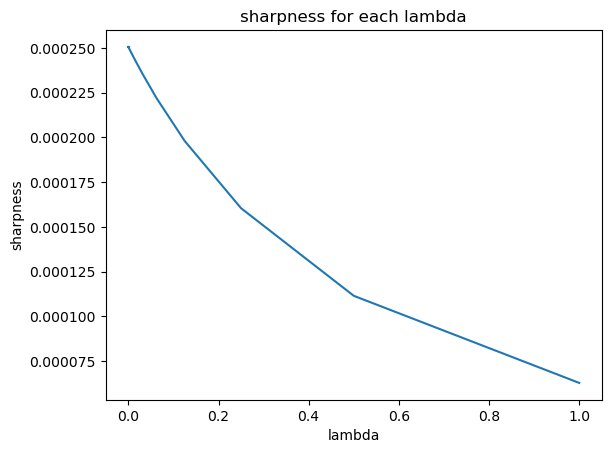

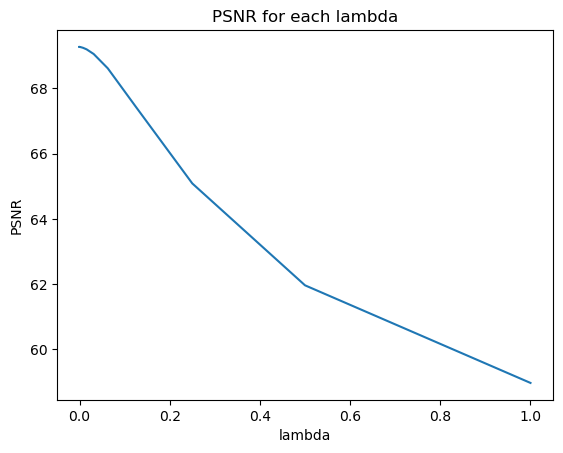

In [56]:
x = []
y = []
z = []
lam = 1
for i in range (1,100):
    x.append(lam)
    b = Tikhonov_deblur_fourier(blurred,h,lam)
    z.append(cv2.PSNR(b, f))
    y.append(sharpness(b))
    lam /= 2
    
plt.plot(x,y)
plt.xlabel('lambda')
plt.ylabel('sharpness')
plt.title("sharpness for each lambda")
plt.show()

plt.plot(x,z)
plt.xlabel('lambda')
plt.ylabel('PSNR')
plt.title("PSNR for each lambda")
plt.show()
      

next we will chaeck how the psf effects the how well the image is able to deblur by taking a constant lambda and changing the sigma on the blur PSF 

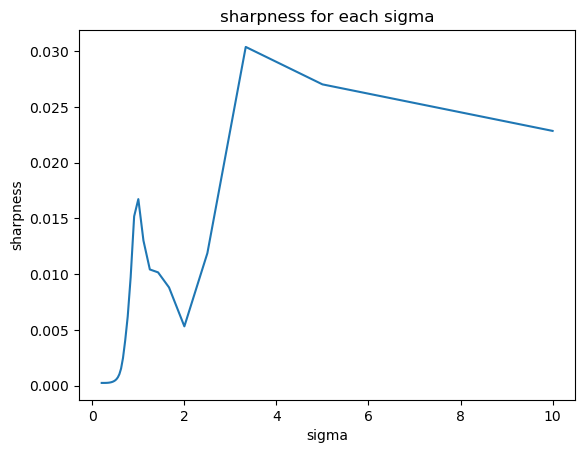

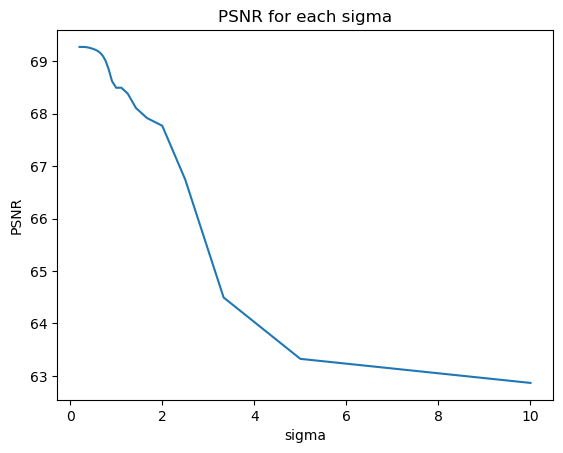

In [66]:
x = []
y = []
z = []
for i in range(1,50):
    psf = h = guassian_kernel(11,11, 10/i)
    b = Tikhonov_deblur_fourier(blurred,psf,0.001)
    x.append(10/i)
    y.append(sharpness(b))
    z.append(cv2.PSNR(b, f))
    
plt.plot(x,y)
plt.xlabel('sigma')
plt.ylabel('sharpness')
plt.title("sharpness for each sigma")
plt.show()   

plt.plot(x,z)
plt.xlabel('sigma')
plt.ylabel('PSNR')
plt.title("PSNR for each sigma")
plt.show()  
